In [61]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import librosa
import numpy as np

In [62]:
# ----- Dataset -----
class ResNetSpectrogramDataset(Dataset):
    def __init__(self, audio_dir, sample_rate=16000, n_mels=128):
        self.audio_dir = audio_dir
        self.files = [f for f in os.listdir(audio_dir) if f.endswith(('.wav', '.m4a'))]
        self.label_map = {'empty': 0, 'half': 1, 'full': 2}
        self.sample_rate = sample_rate

        # Convert audio into a form that deep learning models like ResNet can understand
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=512,
            n_mels=n_mels
        )
        # converts amplitude or power values in a spectrogram into the decibel (dB) scale
        self.db_transform = torchaudio.transforms.AmplitudeToDB()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filename = self.files[idx]
        filepath = os.path.join(self.audio_dir, filename)
        waveform_np, original_sr = librosa.load(filepath, sr=None)
        waveform = torch.tensor(waveform_np).unsqueeze(0)
        if original_sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=original_sr, new_freq=self.sample_rate) # resampling to new sample_rate
            waveform = resampler(waveform)

        mel_spec = self.mel_transform(waveform)
        mel_spec_db = self.db_transform(mel_spec)
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / mel_spec_db.std()

        mel_spec_db = mel_spec_db.unsqueeze(0)  # Now shape: [1, 1, Mels, Time]

        mel_resized = F.interpolate(mel_spec_db, size=(224, 224), mode='bilinear', align_corners=False)

        mel_resized_3ch = mel_resized.repeat(1, 3, 1, 1).squeeze(0)  # Now shape: [3, 224, 224]

        label = -1
        for key in self.label_map:
            if key in filename.lower():
                label = self.label_map[key]
                break
        if label == -1:
            raise ValueError(f"Label not found in filename: {filename}")

        return mel_resized_3ch, label, filename

In [63]:
# ----- Plotting -----
def plot_spectrogram(spec_tensor, title="Mel Spectrogram"):
    spec = spec_tensor[0].cpu().numpy()
    plt.figure(figsize=(6, 4))
    plt.imshow(spec, origin="lower", aspect="auto", cmap="magma")
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.show()

In [64]:
# ----- Training Function -----
def train(model, dataloader, criterion, optimizer, device, epochs=60):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        acc = 100. * correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")

In [65]:
# ----- Main Script -----
if __name__ == "__main__":
    
    data_dir = "bottle_experiment/dataset"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset & DataLoader
    dataset = ResNetSpectrogramDataset(data_dir)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    # Model Setup
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 3)
    model = model.to(device)

    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train
    train(model, dataloader, criterion, optimizer, device, epochs=60)

    # Evaluate one sample
    model.eval()

    # Save model
    torch.save(model.state_dict(), "resnet_waterbottle.pth")


/var/folders/f0/1ms4q4394tq6z6n6kxg9vvw80000gp/T/ipykernel_83040/3166285110.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform_np, original_sr = librosa.load(filepath, sr=None)


Epoch 1, Loss: 5.1115, Accuracy: 51.52%
Epoch 2, Loss: 2.2550, Accuracy: 96.97%
Epoch 3, Loss: 1.3577, Accuracy: 100.00%
Epoch 4, Loss: 1.3484, Accuracy: 100.00%
Epoch 5, Loss: 1.7908, Accuracy: 96.97%
Epoch 6, Loss: 0.9596, Accuracy: 100.00%
Epoch 7, Loss: 1.3261, Accuracy: 96.97%
Epoch 8, Loss: 0.9067, Accuracy: 100.00%
Epoch 9, Loss: 0.9100, Accuracy: 100.00%
Epoch 10, Loss: 0.7727, Accuracy: 100.00%
Epoch 11, Loss: 1.1110, Accuracy: 96.97%
Epoch 12, Loss: 0.8687, Accuracy: 100.00%
Epoch 13, Loss: 0.8951, Accuracy: 100.00%
Epoch 14, Loss: 0.7256, Accuracy: 100.00%
Epoch 15, Loss: 1.1449, Accuracy: 96.97%
Epoch 16, Loss: 0.4195, Accuracy: 100.00%
Epoch 17, Loss: 0.4524, Accuracy: 100.00%
Epoch 18, Loss: 0.5903, Accuracy: 100.00%
Epoch 19, Loss: 0.5334, Accuracy: 100.00%
Epoch 20, Loss: 0.2614, Accuracy: 100.00%
Epoch 21, Loss: 0.2006, Accuracy: 100.00%
Epoch 22, Loss: 0.2148, Accuracy: 100.00%
Epoch 23, Loss: 1.2789, Accuracy: 96.97%
Epoch 24, Loss: 0.2020, Accuracy: 100.00%
Epoch 25

/var/folders/f0/1ms4q4394tq6z6n6kxg9vvw80000gp/T/ipykernel_83040/3166285110.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform_np, original_sr = librosa.load(filepath, sr=None)


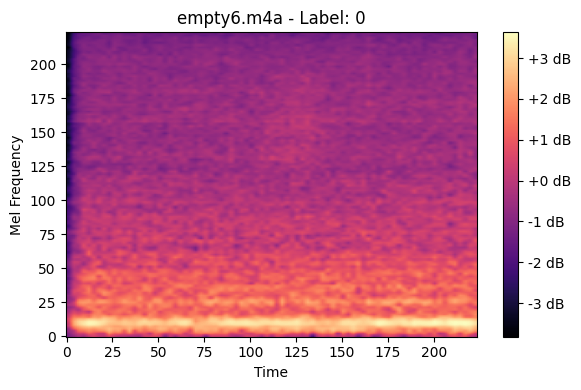

Evaluation: empty6.m4a, Predicted: 0, True Label: 0


In [66]:
sample, label, fname = dataset[1]
plot_spectrogram(sample, title=f"{fname} - Label: {label}")
with torch.no_grad():
        input_tensor = sample.unsqueeze(0).to(device)
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()
        print(f"Evaluation: {fname}, Predicted: {pred}, True Label: {label}")

/Users/shamit/Documents/Projects/RA/cobas/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shamit/Documents/Projects/RA/cobas/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/f0/1ms4q4394tq6z6n6kxg9vvw80000gp/T/ipykernel_83040/3166285110.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform_np, original_sr = librosa.load(filepath, sr=None)
/Users/shamit/Documents/Projects/RA/cobas/venv/lib/python3.9/site-packages/librosa/core/audio.py:184: Fu

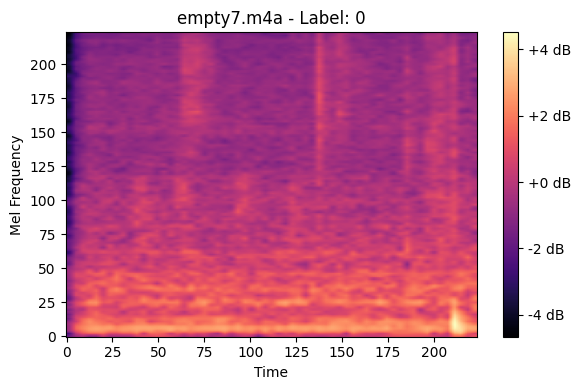

Evaluation: empty7.m4a, Predicted: 0, True Label: 0


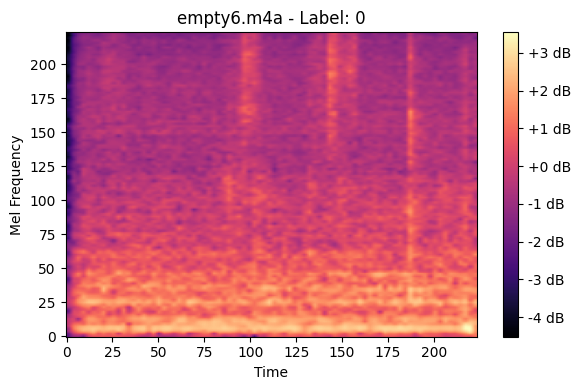

Evaluation: empty6.m4a, Predicted: 0, True Label: 0


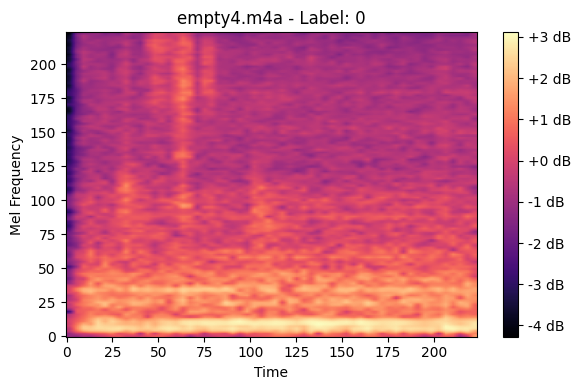

Evaluation: empty4.m4a, Predicted: 0, True Label: 0


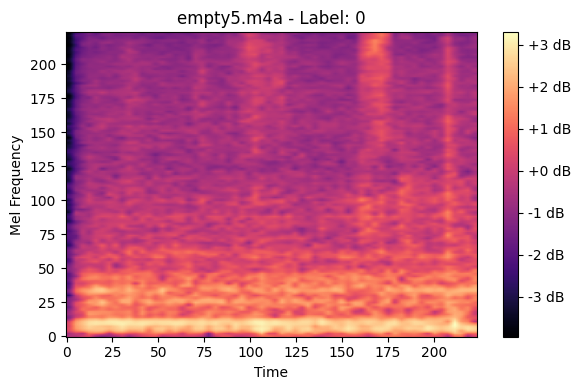

Evaluation: empty5.m4a, Predicted: 0, True Label: 0


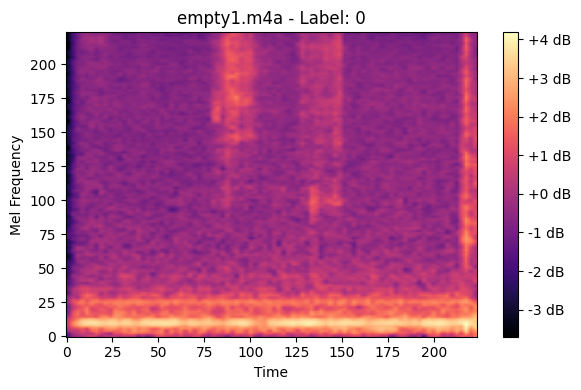

Evaluation: empty1.m4a, Predicted: 0, True Label: 0


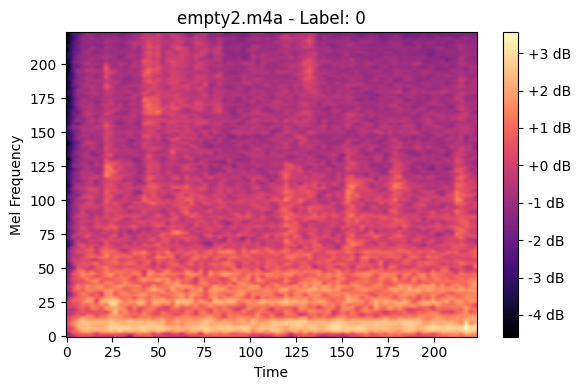

Evaluation: empty2.m4a, Predicted: 0, True Label: 0


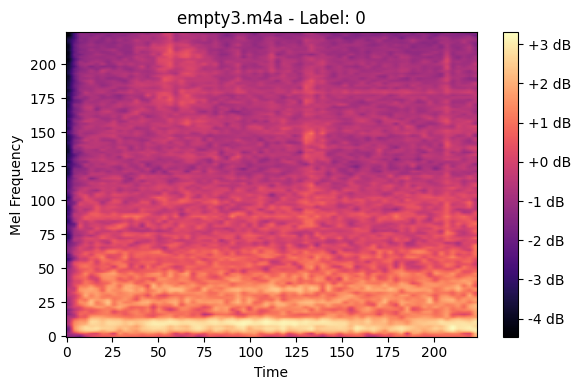

Evaluation: empty3.m4a, Predicted: 0, True Label: 0


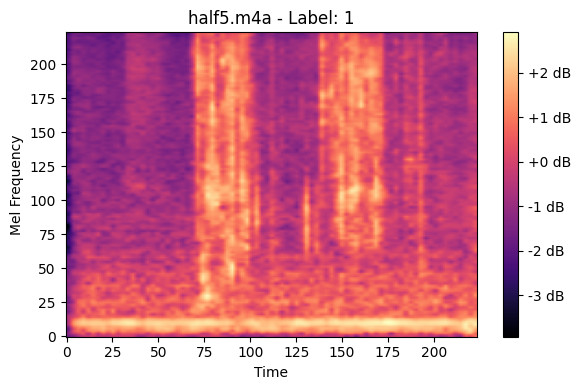

Evaluation: half5.m4a, Predicted: 1, True Label: 1


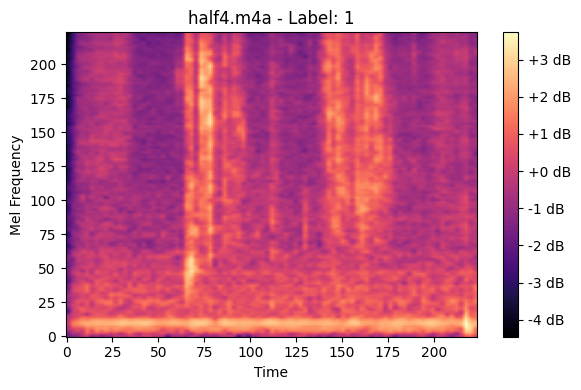

Evaluation: half4.m4a, Predicted: 1, True Label: 1


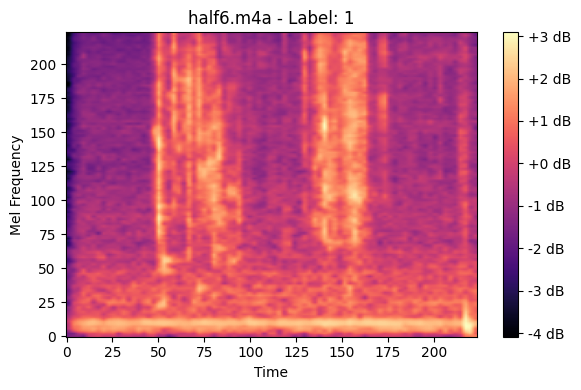

Evaluation: half6.m4a, Predicted: 2, True Label: 1


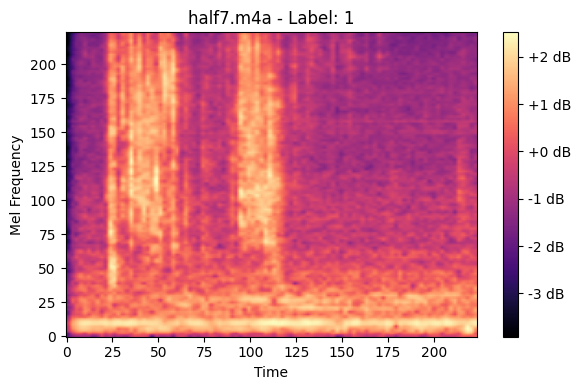

Evaluation: half7.m4a, Predicted: 1, True Label: 1


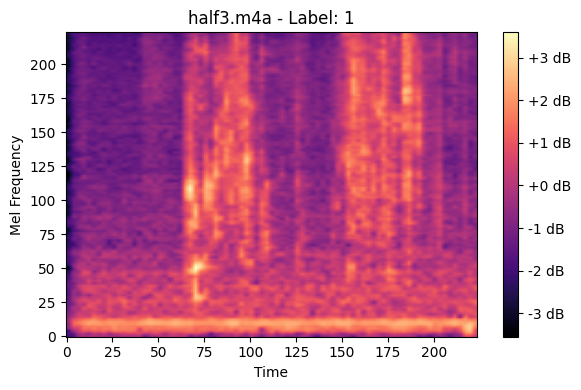

Evaluation: half3.m4a, Predicted: 1, True Label: 1


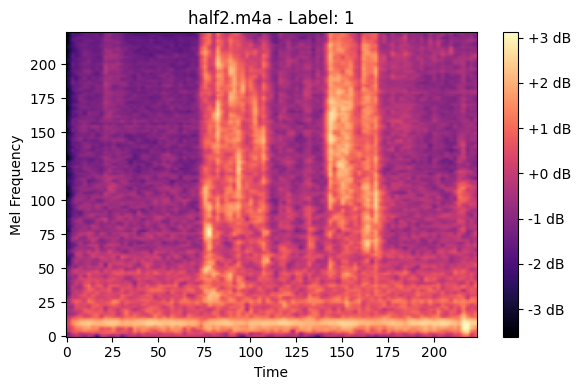

Evaluation: half2.m4a, Predicted: 1, True Label: 1


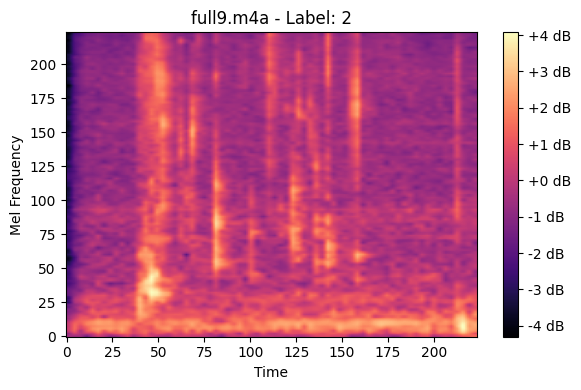

Evaluation: full9.m4a, Predicted: 2, True Label: 2


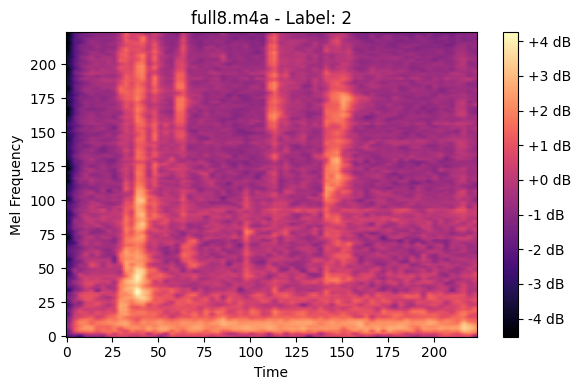

Evaluation: full8.m4a, Predicted: 2, True Label: 2


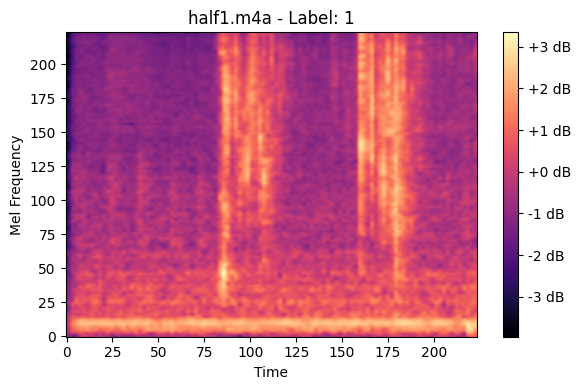

Evaluation: half1.m4a, Predicted: 1, True Label: 1


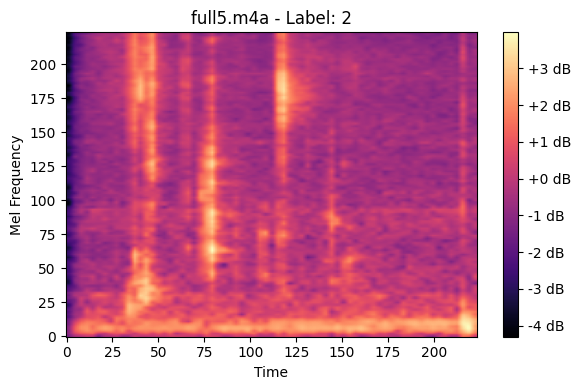

Evaluation: full5.m4a, Predicted: 2, True Label: 2


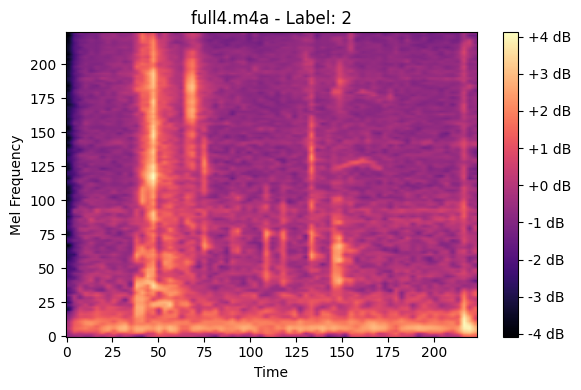

Evaluation: full4.m4a, Predicted: 2, True Label: 2


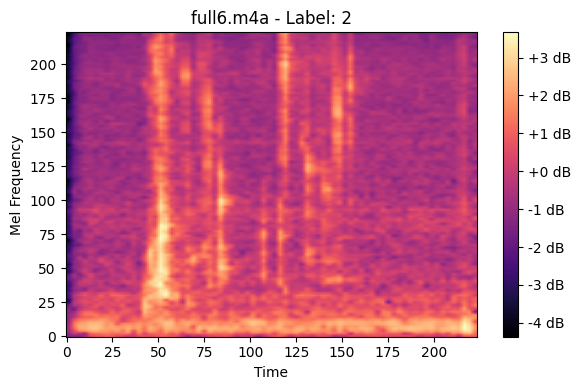

Evaluation: full6.m4a, Predicted: 2, True Label: 2


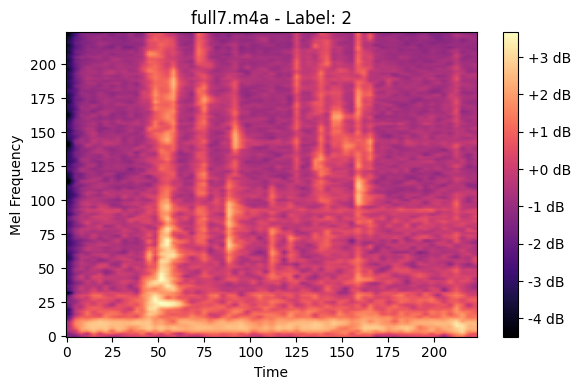

Evaluation: full7.m4a, Predicted: 2, True Label: 2


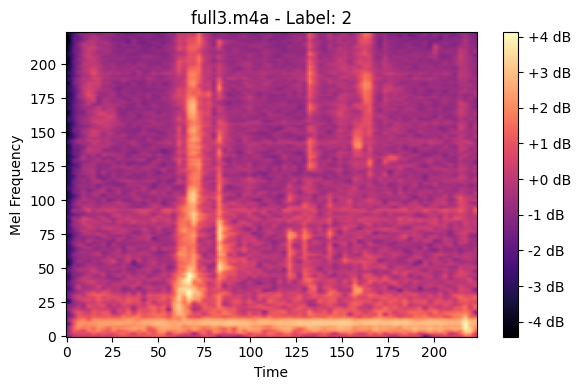

Evaluation: full3.m4a, Predicted: 1, True Label: 2


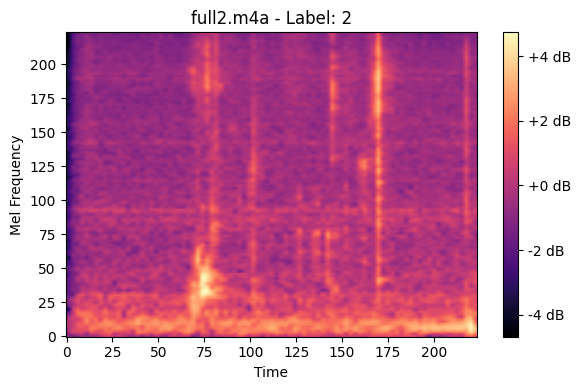

Evaluation: full2.m4a, Predicted: 2, True Label: 2


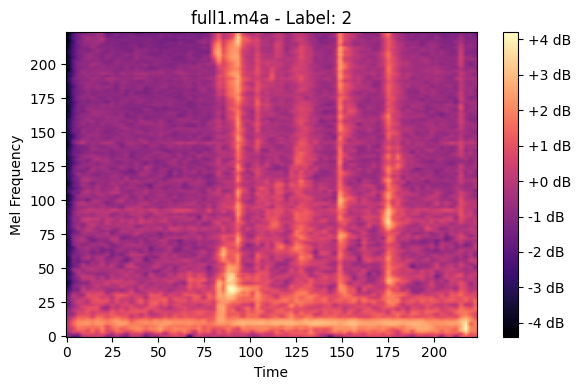

Evaluation: full1.m4a, Predicted: 2, True Label: 2


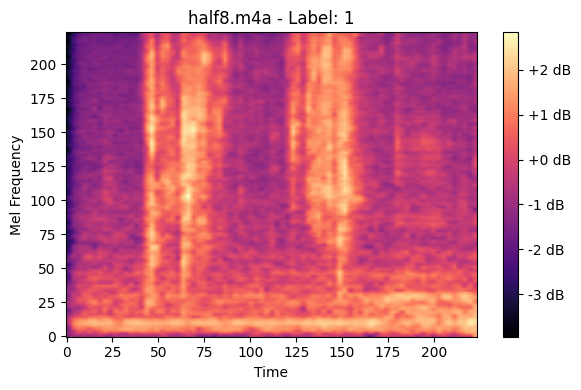

Evaluation: half8.m4a, Predicted: 1, True Label: 1


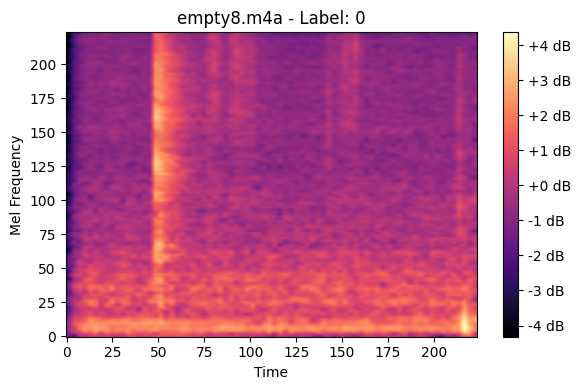

Evaluation: empty8.m4a, Predicted: 2, True Label: 0


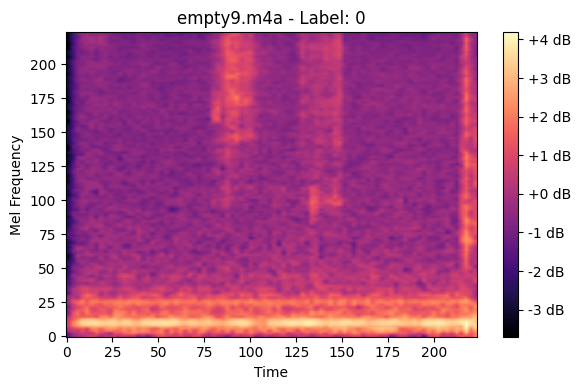

Evaluation: empty9.m4a, Predicted: 0, True Label: 0


In [77]:
import torchvision.models as models
import torch.nn as nn
import torch

# Load ResNet18 and modify the final layer
model = models.resnet18(pretrained=True)  # pretrained=False is fine here
model.fc = nn.Linear(model.fc.in_features, 3)  # ← Match number of classes used during training

# Load the saved weights
model.load_state_dict(torch.load("resnet_waterbottle.pth"))
model.eval()

# Testing the model
test_data_dir = "bottle_experiment/test_dataset"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset & DataLoader
test_dataset = ResNetSpectrogramDataset(test_data_dir)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)
correct = 0
total = 0

true_labels = []
predicted_labels = []

for i in range(0, len(test_dataset)):
    test_sample, test_label, test_fname = test_dataset[i]
    plot_spectrogram(test_sample, title=f"{test_fname} - Label: {test_label}")
    with torch.no_grad():
            test_input_tensor = test_sample.unsqueeze(0).to(device)
            test_output = model(test_input_tensor)
            test_pred = test_output.argmax(dim=1).item()
            true_labels.append(test_label)
            predicted_labels.append(test_pred)
            print(f"Evaluation: {test_fname}, Predicted: {test_pred}, True Label: {test_label}")


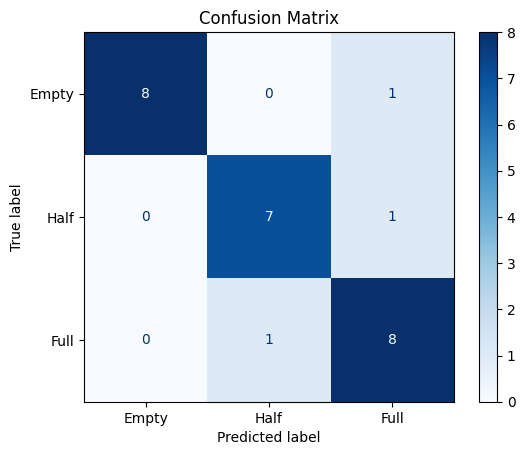

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Empty", "Half", "Full"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()